# Compute SNR

Calculate the SNR of the recordings in the test dataset.

(Rado's implementation of SNR functions is provided at the bottom of the notebook).

**Author**: Prisca Dotti  
**Last modified**: 26/10/2023

TODO (week 44):
- compute snr wrt to events only on chunk that contains them instead of all movie
- change range (`max_range`) in snr wrt to chunks
- try different values of percentile for events in `compute_snr`

In [3]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

import sys

# To import modules from parent directory in Jupyter Notebook
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import logging
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import napari

from utils.in_out_tools import load_movies_ids, load_annotations_ids
from data.data_processing_tools import (
    compute_snr,
    moving_average,
    keep_percentile,
    # get_cell_mask
)

logger = logging.getLogger(__name__)

#### Set working directories and parameters

In [5]:
# list of all movie IDs in test set
sample_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]
# sample_ids = ["05", "34"]

relative_path = "../data/sparks_dataset"
dataset_path = os.path.realpath(f"{relative_path}")

In [6]:
slice_to_movie_id = {
    "01": "15",
    "02": "20",
    "03": "34",
    "04": "05",
    "05": "10",
    "06": "25",
    "07": "32",
    "08": "34",
    "09": "40",
    "10": "45",
}

movie_id_to_slice = {v: k for k, v in slice_to_movie_id.items()}
slice_ids = list(slice_to_movie_id.keys())

slice_to_frame_id = {
    "01": 54,
    "02": 445,
    "03": 430,
    "04": 351,
    "05": 410,
    "06": 109,
    "07": 950,
    "08": 894,
    "09": 898,
    "10": 667,
}

#### Load recordings

In [7]:
# load movies
xs = load_movies_ids(
    data_folder=dataset_path, ids=sample_ids, names_available=True, movie_names="video"
)

In [8]:
# load annotations
ys = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="class_label"
)

In [9]:
# sample_id = sample_ids[1]
# x = xs[sample_id]
# y = ys[sample_id]
# cell_mask = get_cell_mask(x=x)

# viewer = napari.Viewer()
# viewer.add_image(x, name="x")
# viewer.add_labels(y, name="y")
# viewer.add_labels(cell_mask, name="cell_mask")

## Compute SNR

#### For whole movie

In [10]:
snr = {}
for sample_id in sample_ids:
    # get sample
    x = xs[sample_id]
    # get annotations
    y = ys[sample_id]

    # compute signal-to-noise ratio
    snr[sample_id] = compute_snr(x, y)

# visualize snr with respect to samples given to experts for inter-rater
# agreement

# get snr for samples given to experts
snr_experts = {
    slice_id: snr[slice_to_movie_id[slice_id]]
    for slice_id in slice_ids
    if slice_to_movie_id[slice_id] in sample_ids
}

In [38]:
# # plot snr for all samples using seaborn
# sns.set_theme(style="ticks")
# ax = sns.barplot(x=list(snr.keys()), y=list(snr.values()))
# ax.set_title("Signal-to-noise ratio for all samples")
# ax.set_xlabel("Sample ID")
# ax.set_ylabel("SNR")
# ax.bar_label(ax.containers[0], fmt="%.2f");

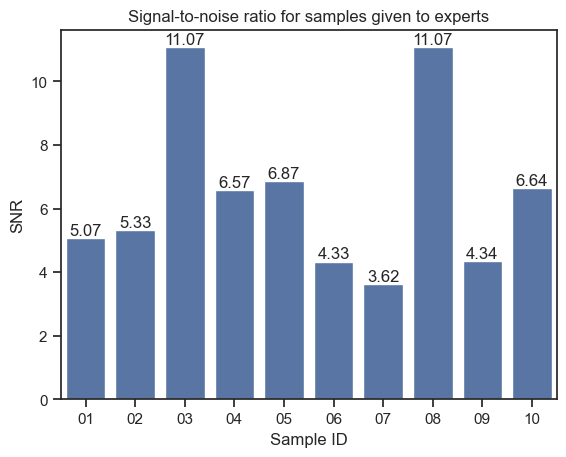

In [36]:
# # print snr_experts as table
# df_snr_experts = pd.DataFrame.from_dict(snr_experts, orient="index", columns=["snr"])
# df_snr_experts = df_snr_experts.rename_axis("slice_id")
# df_snr_experts = df_snr_experts.style.format(precision=2)
# display(df_snr_experts)

# visualize snr for samples given to experts
ax = sns.barplot(x=list(snr_experts.keys()), y=list(snr_experts.values()))
ax.set_title("Signal-to-noise ratio for samples given to experts")
ax.set_xlabel("Sample ID")
ax.set_ylabel("SNR")
ax.bar_label(ax.containers[0], fmt="%.2f")

#### Compute SNR for single frames

In [14]:
snr_frames = {}

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    if movie_id not in sample_ids:
        continue

    # get sample frame
    x = xs[movie_id][frame_id]
    # get annotations frame
    y = ys[movie_id][frame_id]

    # compute signal-to-noise ratio
    snr_frames[slice_id] = compute_snr(x, y)

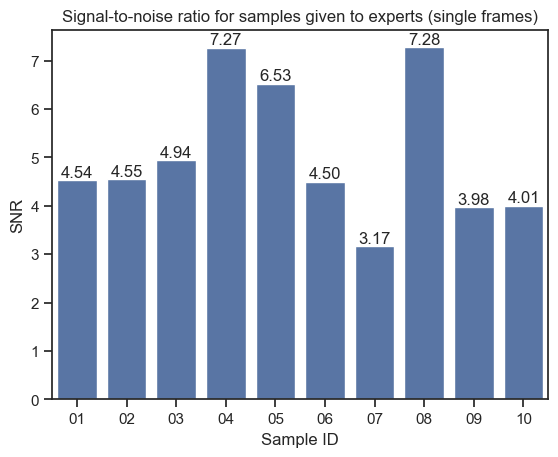

In [35]:
# visualize snr for samples given to experts
ax = sns.barplot(x=list(snr_frames.keys()), y=list(snr_frames.values()))
ax.set_title(
    "Signal-to-noise ratio for samples given to experts (single frames)")
ax.set_xlabel("Sample ID")
ax.set_ylabel("SNR")
ax.bar_label(ax.containers[0], fmt="%.2f")

#### Compute SNR for chunks containing whole events present in slices

In [16]:
# load instance masks for all samples
ys_instances = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="event_label"
)

In [17]:
# Get start and end frames of considered chunk for each sample
start_ids = {}
end_ids = {}

max_range = 16  # maximum range of frames to consider

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]

    if movie_id not in sample_ids:
        continue
    # get all unique event labels in the frame
    event_labels = np.unique(ys_instances[movie_id][frame_id])
    # remove 0 from event_labels
    event_labels = event_labels[event_labels != 0]

    # create variables to store the start and end frames
    start_id = frame_id
    end_id = frame_id

    # loop through each event label
    for event_label in event_labels:
        # get the indices where the event label is present in the frame
        event_indices_list = np.where(ys_instances[movie_id] == event_label)[0]

        # update start_id and end_id
        start_id = min(start_id, event_indices_list[0])
        start_id = max(start_id, frame_id - max_range)

        end_id = max(end_id, event_indices_list[-1])
        end_id = min(end_id, frame_id + max_range)

    start_ids[slice_id] = start_id
    end_ids[slice_id] = end_id

In [18]:
snr_chunks = {}

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    if movie_id not in sample_ids:
        continue

    # get chunk of frames
    start_id = start_ids[slice_id]
    end_id = end_ids[slice_id]
    x_chunk = xs[movie_id][start_id: end_id + 1]
    y_chunk = ys[movie_id][start_id: end_id + 1]

    # compute signal-to-noise ratio
    snr_chunks[slice_id] = compute_snr(x_chunk, y_chunk)

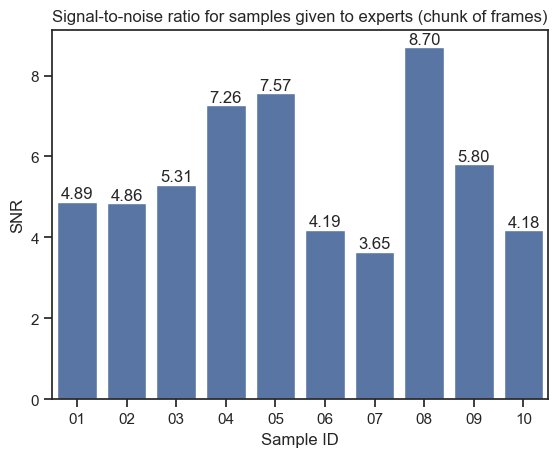

In [34]:
# visualize snr for samples given to experts
ax = sns.barplot(x=list(snr_chunks.keys()), y=list(snr_chunks.values()))
ax.set_title(
    "Signal-to-noise ratio for samples given to experts (chunk of frames)")
ax.set_xlabel("Sample ID")
ax.set_ylabel("SNR")
ax.bar_label(ax.containers[0], fmt="%.2f")

#### Compute average SNR of events present in each slice

In [20]:
# load instance masks for all samples
ys_instances = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="event_label"
)

In [21]:
# initialize dictionary to store average SNR for each slice_id
avg_snr_events = {}

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]

    if movie_id not in sample_ids:
        continue

    x = xs[movie_id]
    y = ys_instances[movie_id]

    # get all unique event labels in the frame
    event_labels = np.unique(ys_instances[movie_id][frame_id])
    # remove 0 from event_labels
    event_labels = event_labels[event_labels != 0]

    # initialize list to store SNR for each event instance
    snr_list = []

    # loop through each event label
    for event_label in event_labels:
        event_roi = np.where(y == event_label, 1, 0)

        # compute signal-to-noise ratio
        snr_event = compute_snr(x=x, y=y, event_roi=event_roi)
        snr_list.append(snr_event)

    # compute the average SNR for all event instances in the slice_id
    avg_snr_events[slice_id] = np.mean(snr_list)

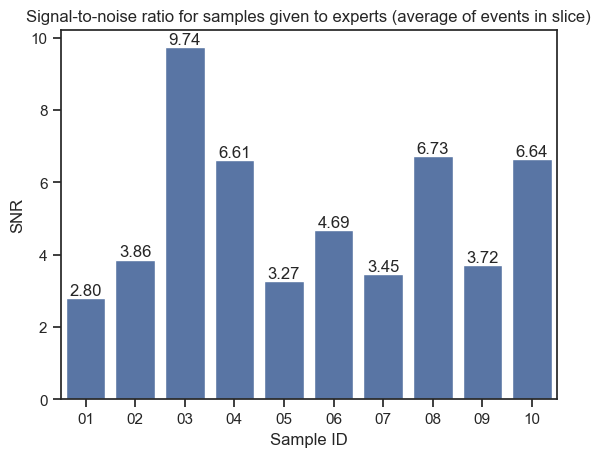

In [33]:
# visualize snr for samples given to experts
ax = sns.barplot(x=list(avg_snr_events.keys()),
                 y=list(avg_snr_events.values()))
ax.set_title(
    "Signal-to-noise ratio for samples given to experts (average of events in slice)"
)
ax.set_xlabel("Sample ID")
ax.set_ylabel("SNR")
ax.bar_label(ax.containers[0], fmt="%.2f")

## Comparison with Fleiss' Kappa

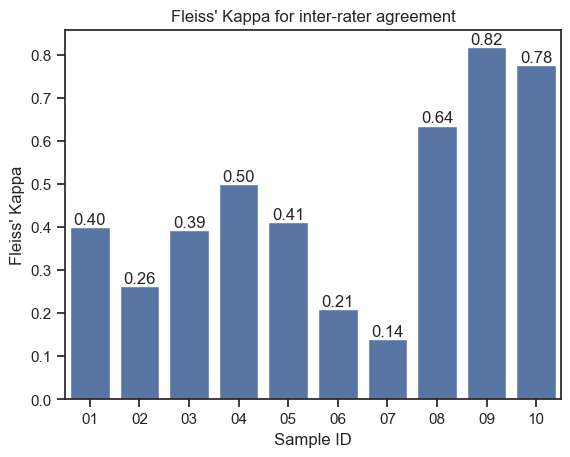

In [31]:
# Fleiss' Kappa for inter-rater agreement
fleiss_kappas = {
    "01": 0.4,
    "02": 0.263,
    "03": 0.393,
    "04": 0.499,
    "05": 0.411,
    "06": 0.210,
    "07": 0.140,
    "08": 0.635,
    "09": 0.817,
    "10": 0.776,
}

# visualize fleiss kappas as barplot
ax = sns.barplot(x=list(fleiss_kappas.keys()), y=list(fleiss_kappas.values()))
ax.set_title("Fleiss' Kappa for inter-rater agreement")
ax.set_xlabel("Sample ID")
ax.set_ylabel("Fleiss' Kappa")
ax.bar_label(ax.containers[0], fmt="%.2f")

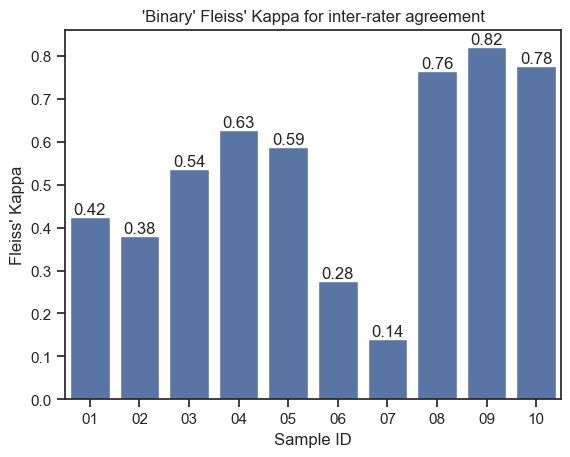

In [32]:
binary_fleiss_kappas = {
    "01": 0.423724,
    "02": 0.379940,
    "03": 0.535884,
    "04": 0.626976,
    "05": 0.587802,
    "06": 0.275065,
    "07": 0.140142,
    "08": 0.764101,
    "09": 0.820575,
    "10": 0.775755,
}

# visualize fleiss kappas as barplot
ax = sns.barplot(x=list(fleiss_kappas.keys()),
                 y=list(binary_fleiss_kappas.values()))
ax.set_title("'Binary' Fleiss' Kappa for inter-rater agreement")
ax.set_xlabel("Sample ID")
ax.set_ylabel("Fleiss' Kappa")
ax.bar_label(ax.containers[0], fmt="%.2f")

In [25]:
fleiss_kappas_list = [
    kappa
    for slice_id, kappa in fleiss_kappas.items()
    if slice_to_movie_id[slice_id] in sample_ids
]

binary_fleiss_kappas_list = [
    kappa
    for slice_id, kappa in binary_fleiss_kappas.items()
    if slice_to_movie_id[slice_id] in sample_ids
]

#### For whole movies

Pearsons correlation for classified segmentation: 0.280
Pearsons correlation for binary segmentation: 0.469


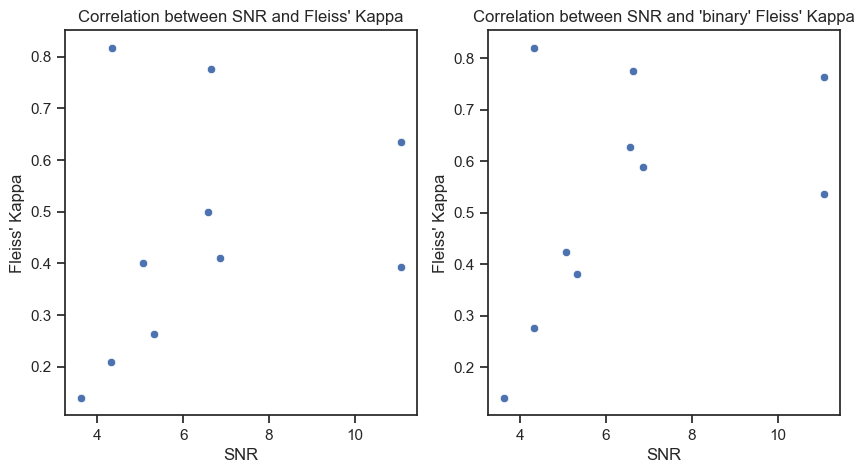

In [26]:
# check if there is a correlation between snr and fleiss kappas
snr_experts_list = list(snr_experts.values())
corr, _ = pearsonr(snr_experts_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % corr)

# check if there is a correlation between snr and binary fleiss kappas
corr, _ = pearsonr(snr_experts_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % corr)

# create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# visualize snr and fleiss kappas as scatterplot
sns.scatterplot(x=snr_experts_list, y=fleiss_kappas_list, ax=ax1)
ax1.set_title("Correlation between SNR and Fleiss' Kappa")
ax1.set_xlabel("SNR")
ax1.set_ylabel("Fleiss' Kappa")

# visualize snr and binary fleiss kappas as scatterplot
sns.scatterplot(x=snr_experts_list, y=binary_fleiss_kappas_list, ax=ax2)
ax2.set_title("Correlation between SNR and 'binary' Fleiss' Kappa")
ax2.set_xlabel("SNR")
ax2.set_ylabel("Fleiss' Kappa")

# display the plot
plt.show()

#### Compute correlation for single frames

Pearsons correlation for classified segmentation: 0.192
Pearsons correlation for binary segmentation: 0.427


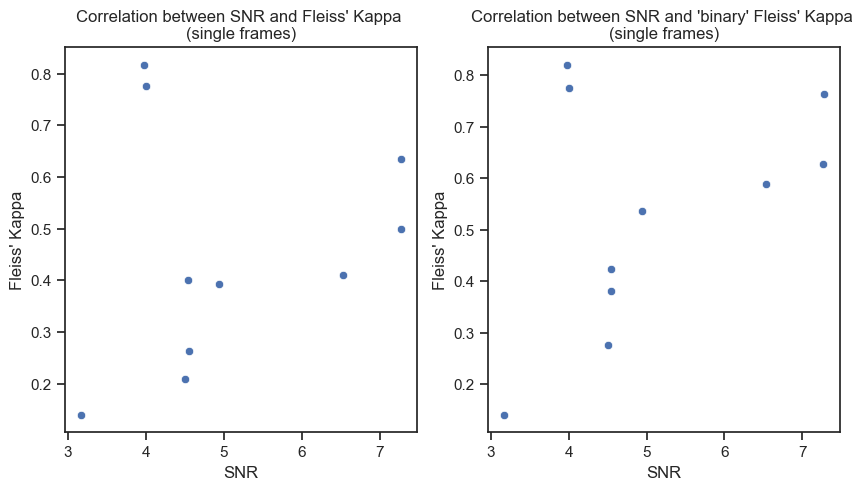

In [27]:
# check if there is a correlation between snr and fleiss kappas
snr_frames_list = list(snr_frames.values())
corr, _ = pearsonr(snr_frames_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % corr)

# check if there is a correlation between snr and binary fleiss kappas
corr, _ = pearsonr(snr_frames_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % corr)

# create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# visualize snr and fleiss kappas as scatterplot
sns.scatterplot(x=snr_frames_list, y=fleiss_kappas_list, ax=ax1)
ax1.set_title("Correlation between SNR and Fleiss' Kappa \n(single frames)")
ax1.set_xlabel("SNR")
ax1.set_ylabel("Fleiss' Kappa")

# visualize snr and binary fleiss kappas as scatterplot
sns.scatterplot(x=snr_frames_list, y=binary_fleiss_kappas_list, ax=ax2)
ax2.set_title(
    "Correlation between SNR and 'binary' Fleiss' Kappa \n(single frames)")
ax2.set_xlabel("SNR")
ax2.set_ylabel("Fleiss' Kappa")

# display the plot
plt.show()

#### Compute correlation for chunks containing whole events present in slices

Pearsons correlation for classified segmentation: 0.382
Pearsons correlation for binary segmentation: 0.589


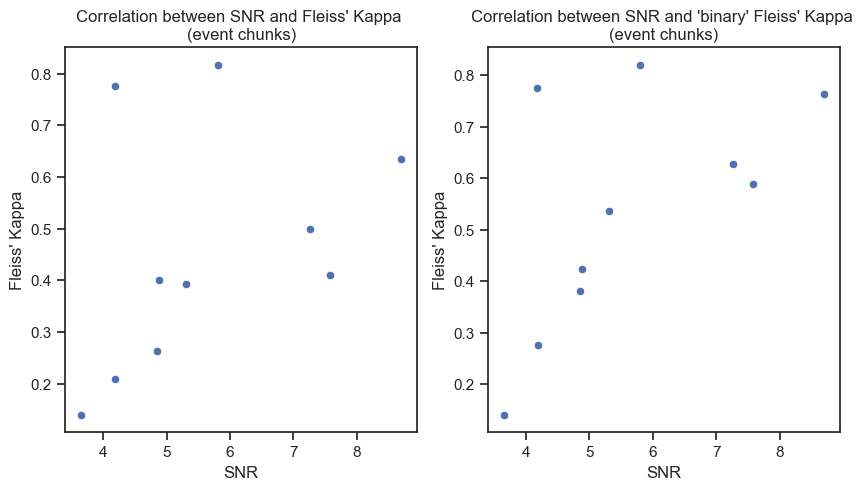

In [28]:
# check if there is a correlation between snr and fleiss kappas
snr_chunks_list = list(snr_chunks.values())
corr, _ = pearsonr(snr_chunks_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % corr)

# check if there is a correlation between snr and binary fleiss kappas
corr, _ = pearsonr(snr_chunks_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % corr)

# create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# visualize snr and fleiss kappas as scatterplot
sns.scatterplot(x=snr_chunks_list, y=fleiss_kappas_list, ax=ax1)
ax1.set_title("Correlation between SNR and Fleiss' Kappa \n(event chunks)")
ax1.set_xlabel("SNR")
ax1.set_ylabel("Fleiss' Kappa")

# visualize snr and binary fleiss kappas as scatterplot
sns.scatterplot(x=snr_chunks_list, y=binary_fleiss_kappas_list, ax=ax2)
ax2.set_title(
    "Correlation between SNR and 'binary' Fleiss' Kappa \n(event chunks)")
ax2.set_xlabel("SNR")
ax2.set_ylabel("Fleiss' Kappa")

# display the plot
plt.show()

#### Compute correlation of average of events present in each slice

Pearsons correlation for classified segmentation: 0.249
Pearsons correlation for binary segmentation: 0.356


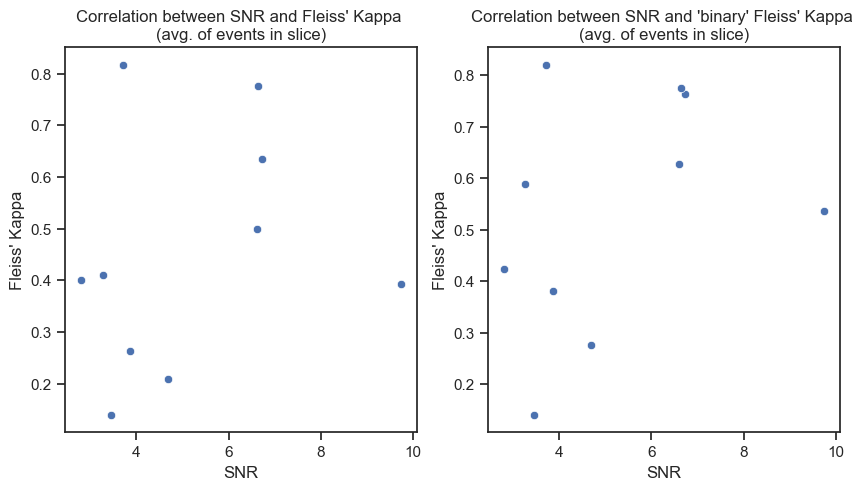

In [29]:
# check if there is a correlation between snr and fleiss kappas
avg_snr_events_list = list(avg_snr_events.values())
corr, _ = pearsonr(avg_snr_events_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % corr)

# check if there is a correlation between snr and binary fleiss kappas
corr, _ = pearsonr(avg_snr_events_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % corr)

# create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# visualize snr and fleiss kappas as scatterplot
sns.scatterplot(x=avg_snr_events_list, y=fleiss_kappas_list, ax=ax1)
ax1.set_title(
    "Correlation between SNR and Fleiss' Kappa \n(avg. of events in slice)")
ax1.set_xlabel("SNR")
ax1.set_ylabel("Fleiss' Kappa")

# visualize snr and binary fleiss kappas as scatterplot
sns.scatterplot(x=avg_snr_events_list, y=binary_fleiss_kappas_list, ax=ax2)
ax2.set_title(
    "Correlation between SNR and 'binary' Fleiss' Kappa \n(avg. of events in slice)"
)
ax2.set_xlabel("SNR")
ax2.set_ylabel("Fleiss' Kappa")

# display the plot
plt.show()

## Rado's functions implementation

In [30]:
# from skimage.morphology import binary_closing

# def estimate_cell_mask(cell_img: np.ndarray) -> np.ndarray:
#     cell_img = np.mean(cell_img, axis=0)

#     # Normalize cell image
#     cell_img = cell_img / np.max(cell_img)

#     # Calculate a threshold using Otsu's method
#     cell_thrs = threshold_otsu(
#         cell_img[
#             (cell_img > np.percentile(cell_img, 1))
#             & (cell_img < np.percentile(cell_img, 99))
#         ]
#     )

#     # Create a binary thresholded cell image
#     cell_img_bw_thrs = binary_fill_holes(cell_img > cell_thrs)

#     # Perform edge detection and dilation to obtain cell mask
#     edges_sobel = (
#         cell_img > np.max(cell_img) * 0.5
#     )  # You might need to fine-tune this threshold
#     edges_canny = cell_img_bw_thrs

#     se = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])  # Define a structuring element
#     bw_dil_sobel = binary_closing(edges_sobel, se)
#     bw_dil_canny = binary_closing(edges_canny, se)

#     cell_mask = bw_dil_sobel | bw_dil_canny | cell_img_bw_thrs
#     cell_mask = binary_fill_holes(cell_mask)

#     return cell_mask

# def estimate_snr(x: np.ndarray, y: np.ndarray, event_type: str) -> float:
#     # Convert the image series to double
#     x = x.astype(float)

#     # Estimate the cell mask
#     cell_mask = estimate_cell_mask(x)

#     # Add the mask of events to the cell mask
#     cell_mask = cell_mask | np.any(y, axis=0)
#     cell_mask = np.repeat(cell_mask[np.newaxis, :, :], x.shape[0], axis=0)

#     # Calculate the 99th percentile of event mask as the peak amplitude of events
#     p = 99

#     if event_type == "sparks":
#         avg_events = np.percentile(x[cell_mask & (y == 1)], p)
#     elif event_type == "puffs":
#         avg_events = np.percentile(x[cell_mask & (y == 3)], p)
#     elif event_type == "waves":
#         avg_events = np.percentile(x[cell_mask & (y == 2)], p)
#     elif event_type == "all":
#         avg_events = np.percentile(x[cell_mask & np.isin(y, [1, 2, 3])], p)
#     else:
#         raise ValueError(
#             "event_type must be one of the following: sparks, puffs, waves or all"
#         )

#     # Calculate the average signal from cell areas without events
#     avg_baseline = np.mean(x[(y == 0) & cell_mask])

#     # Estimate noise standard deviation
#     sd_noise = np.std(x[(y == 0) & cell_mask])

#     # Calculate SNR
#     snr = (avg_events - avg_baseline) / sd_noise

#     return snr